# Dimensionality Reduction and clustering for identification of putative MEC-Hippocampal circuit cells from in-vivo extracellular recordings.

### Group Yeti fans: Aya Sullivan, Vaishali Gautam, Rita Fischer 

### Note that WaveMAP has been implemented on the Macaque premotor cortex data (Lee et al. 2021), and has been submitted alongside this notebook separately.

## Research Question

How do different dimensionality reduction techniques–PCA, UMAP, and t-SNE–combined with k-means clustering compare to WaveMAP in their ability to group processed extracellular waveforms from the Macaque premotor cortex? How do different dimensionality reduction techniqeus in combination with K-means clustering perform to group raw extracellular waveforms from the mouse medial entorhinal cortex? Which method most effectively and efficiently preserves waveform characteristics for identifying putative cell types?

## Abstract

This project compares k-means clustering on Principal Component Analysis (PCA), Uniform Manifold Approximation and Projection (UMAP), and t-distributed Stochastic Neighbor Embedding (t-SNE) to Waveform Manifold Approximation and Projection (WaveMAP), which uses Louvain community detection on UMAP for dimensionality reduction of extracellular waveforms to identify neuronal cell types. By applying these techniques on electrophysiological data from the medial entorhinal cortex, we aim to evaluate the efficacy of each method in maintaining waveform characteristics and identifying distinct cell types. Our findings highlight the advantages and limitations of each dimensionality reduction technique and provide insights into their application for spike sorting in neurophysiological research.

## Background

Dimensionality reduction techniques are used to reduce the complexity of data, with each method using different mathematical models that can result in different conclusions. This project aims to compare Principal Component Analysis (PCA), Uniform Manifold Approximation and Projection (UMAP), t-distributed Stochastic Neighbor Embedding (t-SNE), and Waveform Manifold Approximation and Projection (WaveMAP) performed in "Non-linear Dimensionality Reduction on Extracellular Waveforms Reveals Physiological, Functional, and Laminar Diversity in Premotor Cortex" (Lee et al., 2021). PCA determines axes in a high-dimensional space that can express information with fewer variables than the original dataset. t-SNE preserves the local structure of the data by converting pairwise distances between points into probabilities and minimizing divergence in high and low-dimensional space. UMAP is used to reduce high-dimensional data into a 2d space for visualization and analysis of non-linear data (Yang et al., 2021).

WaveMAP combines UMAP with Louvain community detection for complex neuronal population dynamics. It characterizes cells according to their electrophysiology features, namely their waveform shape, as it exposes more diversity in extracellular waveform shape than any single constructed spike feature (Lee et al., 2021). It takes preprocessed electrophysiology data that has been spike-sorted and averaged. The waveforms should be normalized before being dimensionally reduced so they are grouped based on their features and shape instead of the differences in amplitudes and other drastic metrics. WaveMAP implements an unsupervised clustering algorithm called Louvain clustering over the UMAP projection of all the waveforms to group data based on proximity in the 2D projection space. The waveforms can be extracted by their cluster and analyzed for features indicative of their cell type (Lee et al., 2021).

Non-linear Dimensionality Reduction on Extracellular Waveforms Reveals Physiological, Functional, and Laminar Diversity in Premotor Cortex (Lee et al., 2021) utilizes WaveMAP to isolate extracellular waveforms from the dorsal premotor cortex of macaque monkeys during a decision-making task. The goal of the paper was to understand how decision-related dynamics emerge across putative cell types using WaveMAP. The waveforms revealed novel diversity within the subtypes, showing laminar distributions, firing patterns, and decision-related dynamics. In this project, we adapted WaveMAP using PCA, t-SNE, and UMAP to compare how these dimensionality reduction techniques extracted waveforms from the same population. K-means clustering, a supervised learning technique that randomly chooses cluster centers and iteratively groups data points based on their proximity to a cluster center, was used to identify and group waveforms.

To validate the use of dimensionality reduction and clustering to identify diversity in unprocessed waveforms, we performed our WaveMAP-inspired analysis using PCA, t-SNE, UMAP, and K-means clustering on a recording from the medial entorhinal cortex during open field navigation. The dataset contains raw electrophysiology data from 34 subjects, including metadata such as LFP, position, units, electrode group, eye tracking, spatial series, and processing modules. For simplicity and proof of concept, we apply our method to 7 out of 384 total channels containing 100-second raw electrophysiology recording from the electrical series dataset with 300000 timepoints for each channel (Mallory et al., 2021). We aim to identify putative cell types associated with those recorded from in the medial entorhinal cortex and identify whether there are advantages in using certain grouping techniques over others.

# Data Wrangling

Import packages required for data wrangling.

In [1]:
#!pip install dandi
#!pip install umap_learn
#!pip install pynwb

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
from sklearn import datasets
from PIL import Image
import base64
import random
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
import os
from scipy import io
import pickle as pkl
import h5py
import xml.etree.ElementTree as ET

Let's get our dataset from DANDI: An in-vivo extracellular medial entorhinal cortex (MEC) recording session from Lisa Giocomo's lab at Stanford.

In [2]:
dandiset_id = '000053' # giocomo data
filepath = 'sub-npI5/sub-npI5_ses-20190414_behavior+ecephys.nwb'

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)

print(s3_path)

A newer version (0.62.1) of dandi/dandi-cli is available. You are using 0.61.2


https://dandiarchive.s3.amazonaws.com/blobs/d6d/882/d6d88284-983a-42a7-91e8-48e9f59c2881


In [3]:
try:
    with NWBHDF5IO(s3_path, mode='r', load_namespaces=True, driver='ros3') as io:
        nwbfile = io.read()
        ephys_99 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,99])*nwbfile.acquisition['ElectricalSeries'].conversion
        ephys_42 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,42])*nwbfile.acquisition['ElectricalSeries'].conversion
        ephys_249 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,249])*nwbfile.acquisition['ElectricalSeries'].conversion
        ephys_158 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,158])*nwbfile.acquisition['ElectricalSeries'].conversion
        ephys_207 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,207])*nwbfile.acquisition['ElectricalSeries'].conversion
        ephys_198 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,198])*nwbfile.acquisition['ElectricalSeries'].conversion
        ephys_179 = (nwbfile.acquisition['ElectricalSeries'].data[:300000,179])*nwbfile.acquisition['ElectricalSeries'].conversion        

        units_df = nwbfile.units.to_dataframe()

        #print(f"Data shape: {nwbfile.acquisition['ElectricalSeries'].data.shape}")

except ValueError:
    print('Environment is not configured for pynwb.')
    ephys_data = []
    fs = 400

/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [4]:
#SET GLOBAL PARAMETERS
# Define indices of channels with good waveforms
good_waveform_indices = [99, 42, 249, 158, 207, 198, 179]

#get sampling rate.
fs = nwbfile.acquisition['ElectricalSeries'].rate # get the sampling frequency in Hz
print(fs)

#color palettes
viridis_colors = [ '#440154', '#482777', '#3f4a89', '#31688e', '#26838f','#1f9d8a', '#6cce5a' , '#b6de2b', '#fee825', '#fde724'] 
colors = ['#00c49a', '#ffca3a', '#D81159', '#fe7f2d', '#7bdff2', '#0496ff', '#efa6c9', '#ced4da', '#000435','#5e60ce']
cluster_colors = ['#00c49a', '#ffca3a', '#D81159', '#fe7f2d', '#7bdff2', '#0496ff', '#efa6c9', '#ced4da', '#000435','#5e60ce']

# BLUE COLOR
BlueCol = '\033[94m'

#metrics to define cutout window, totaling 2ms to exclude subsequent spikes
pre = 0.0005
post = 0.0015

30000.0


After randomly selecting and reviewing around 10 channels, we identified 7 with at least one good unit which we will be using for the following analysis.

Quantify noise level in the extracellular recordings for each specified channel using standard deviation. Determine a detection threshold for each channel based on noise level. This will allow for detecting spikes by setting adaptive thresholds tailored to the noise level of each recording channel. 

In [5]:
#Standard deviation for each channel 
noise_std99 = np.std(ephys_99)
noise_std42 = np.std(ephys_42)
noise_std249 = np.std(ephys_249)
noise_std158 = np.std(ephys_158)
noise_std207 = np.std(ephys_207)
noise_std198 = np.std(ephys_198)
noise_std179 = np.std(ephys_179)

#Recommended threshold for each channel 
recommended_threshold99 = -5 * noise_std99
recommended_threshold42  = -5 * noise_std42
recommended_threshold249 = -5 * noise_std249
recommended_threshold158 = -5 * noise_std158
recommended_threshold207 = -5 * noise_std207
recommended_threshold198 = -5 * noise_std198
recommended_threshold179 = -5 * noise_std179

In [1]:
#Functions to align waveforms, adapted from BIPN162 NWB notebook.

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array

    The signal transitions from a sample above the threshold to a sample below the threshold for a detection and
    the last detection has to be more than dead_time apart from the current one.
    
    Parameters
      signal: The signal as a 1-dimensional numpy array
      fs: The sampling frequency in Hz
      threshold: The threshold for the signal
      dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index
    
    Parameters
      signal: The signal as a 1-dimensional numpy array
      index: The scalar index
      max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings
    
    Parameters
      signal: The signal as a 1-dimensional numpy array
      fs: The sampling frequency in Hz
      threshold_crossings: The array of indices where the signal crossed the detection threshold
      search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

In [7]:
crossings99 = detect_threshold_crossings(ephys_99, fs, recommended_threshold99, 0.003) 
spks99 = align_to_minimum(ephys_99, fs, crossings99, 0.002)

crossings42 = detect_threshold_crossings(ephys_42, fs, recommended_threshold42, 0.003) 
spks42 = align_to_minimum(ephys_42, fs, crossings42, 0.002)

crossings249 = detect_threshold_crossings(ephys_249, fs, recommended_threshold249, 0.003) 
spks249 = align_to_minimum(ephys_249, fs, crossings249, 0.002)

crossings158 = detect_threshold_crossings(ephys_158, fs, recommended_threshold158, 0.003) 
spks158 = align_to_minimum(ephys_158, fs, crossings158, 0.002)

crossings207 = detect_threshold_crossings(ephys_207, fs, recommended_threshold207, 0.003) 
spks207 = align_to_minimum(ephys_207, fs, crossings207, 0.002)

crossings198 = detect_threshold_crossings(ephys_198, fs, recommended_threshold198, 0.003) 
spks198 = align_to_minimum(ephys_198, fs, crossings198, 0.002)

crossings179 = detect_threshold_crossings(ephys_179, fs, recommended_threshold179, 0.003) 
spks179 = align_to_minimum(ephys_179, fs, crossings179, 0.002)

In [8]:
#Function to extract and plot aligned waveforms, adapted from BIPN162 NWB notebook.

def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    Parameters
      signal: The signal as a 1-dimensional numpy array
      fs: The sampling frequency in Hz
      spikes_idx: The sample index of all spikes as a 1-dim numpy array
      pre: The duration of the cutout before the spike in seconds
      post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)
    print(spike_idx)

def plot_waveforms(cutouts, fs, pre, post, n=100):
    """
    Plot an overlay of spike cutouts
    
    Parameters
      cutouts: A spikes x samples array of cutouts
      fs: The sampling frequency in Hz
      pre: The duration of the cutout before the spike in seconds
      post: The duration of the cutout after the spike in seconds
      n: The number of cutouts to plot, or None to plot all. Default: 100
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre, post, 1/fs)
    plt.figure(figsize=(12,6))

    for i in range(n):
        plt.plot(time_in_us, cutouts[i,], color='k', linewidth=1, alpha=0.3)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)' )

    plt.show()

Let's try plotting spikes from one channel of our data to see how this looks. 

In [9]:
print('\n         Channel 99')
noisy99 = extract_waveforms(ephys_99, fs, spks99, pre, post)
plot_waveforms(noisy99, fs, pre, post, n=500)
min_voltagenoise99 = np.amin(noisy99, axis=1)
max_voltagenoise99 = np.amax(noisy99, axis=1)


         Channel 99


This looks okay, but we can imagine that by superimposing spikes from many channels it would be impossible to visualize or pick out units or their features. Before we spike sort, to more earily isolate good action potential waveforms, we will apply a butterworth filter to each channel. This will move any high and low frequency noise that is outside of the range of an action potential frequency, since that is the only thing we're interested in. Because dimensionality reduction models will treat each time point as an independent feature, they are very sensitive to noise - thus, we want to smooth our data so that the factors taken most into account by our projections are features like waveform shape, amplitude, broad vs. narrow spikes, and other features that are intrinsic to different cell types. We could also remove any spikes with an ISI violation, meaning that they spike again within our window or ones that have too high of a signal:noise ratio. 

In [10]:
#butterworth filter
from scipy.signal import butter, filtfilt

# Define Butterworth filter parameters
lowcut = 350.0  # Low cutoff frequency (Hz)
highcut = 2500.0  # High cutoff frequency (Hz)
order = 4  # Filter order

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [11]:
#compute signal-noise ratio in order to eliminate artifacts - need to adjust params bc this was too strict (maybe don't use)
def compute_snr(waveforms):
    W_bar = np.nanmean(waveforms, axis=0)
    sig_amp = np.max(W_bar) - np.min(W_bar)
    noise = waveforms - np.tile(W_bar, (np.shape(waveforms)[0], 1))
    snr = sig_amp / (2 * np.nanstd(noise.flatten()))
    return snr

#compute ISI metrics to eliminate waveforms which have multiple spikes in the window
def compute_isi_metrics(spike_train, fs, isi_threshold=0.0015):
    duration = np.max(spike_train) - np.min(spike_train)
    firing_rate = spike_train.size / duration
    isis = np.diff(spike_train)
    num_spikes = spike_train.size
    num_violations = np.sum(isis < isi_threshold)
    violation_time = 2 * num_spikes * isi_threshold
    violation_rate = num_violations / violation_time
    isi_violation_percentage = (violation_rate / firing_rate) * 100
    return isi_violation_percentage

In [12]:
#apply butterworth filter to our data
filt_99 = butter_bandpass_filter(ephys_99, lowcut, highcut, fs, order)
filt_42 = butter_bandpass_filter(ephys_42, lowcut, highcut, fs, order)
filt_249 = butter_bandpass_filter(ephys_249, lowcut, highcut, fs, order)
filt_158 = butter_bandpass_filter(ephys_158, lowcut, highcut, fs, order)
filt_207 = butter_bandpass_filter(ephys_207, lowcut, highcut, fs, order)
filt_179 = butter_bandpass_filter(ephys_179, lowcut, highcut, fs, order)
filt_198 = butter_bandpass_filter(ephys_198, lowcut, highcut, fs, order)


         Channel 99


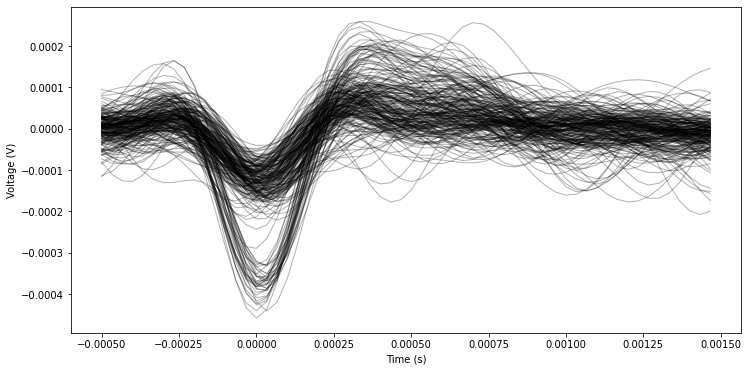

In [13]:
print('\n         Channel 99')

try:
    waveforms99 = extract_waveforms(filt_99, fs, spks99, pre, post)
    plot_waveforms(waveforms99, fs, pre, post, n=500)
    min_voltage99 = np.amin(waveforms99, axis=1)
    max_voltage99 = np.amax(waveforms99, axis=1)

except ValueError:
    print('No data loaded.')
    min_voltage, max_voltage = 0,0


We can see here that there appear to be two peaks, which can occur when a recording electrode is in between multiple cells. Oftentimes we can perform PCA or another feature extraction technique to separate out the two units. But, if we don't know how many units are on each channel this type of processing would have to be iterated through each channel. Later on, we can perform dimensionality reduction across multiple channels and see how well it performs to separate out individual units.


          Channel 42


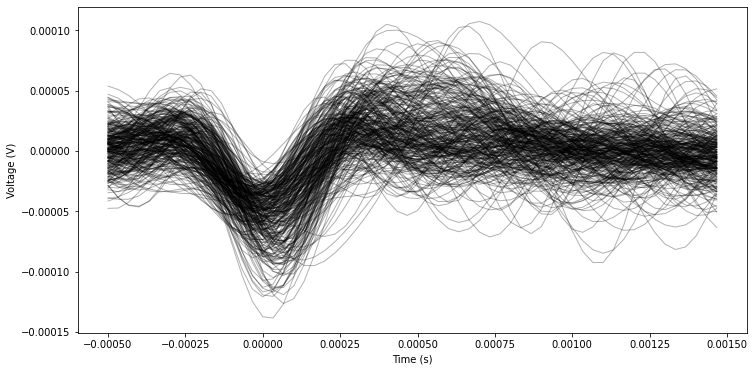

In [14]:
print('\n          Channel 42')

try:
    waveforms42 = extract_waveforms(filt_42, fs, spks42, pre, post)
    plot_waveforms(waveforms42, fs, pre, post, n=500)
    min_voltage42 = np.amin(waveforms42, axis=1)
    max_voltage42 = np.amax(waveforms42, axis=1)

except ValueError:
    print('No data loaded.')
    min_voltage, max_voltage = 0,0



          Channel 249


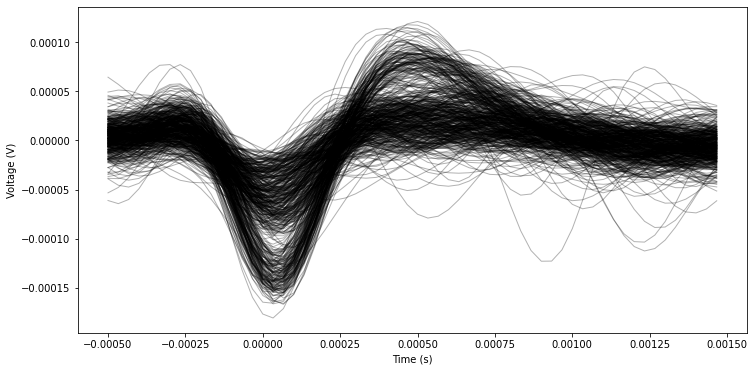

In [15]:
print('\n          Channel 249')

try:
    waveforms249 = extract_waveforms(filt_249, fs, spks249, pre, post)
    plot_waveforms(waveforms249, fs, pre, post, n=500)
    min_voltage249 = np.amin(waveforms249, axis=1)
    max_voltage249 = np.amax(waveforms249, axis=1)

except ValueError:
    print('No data loaded.')
    min_voltage, max_voltage = 0,0


Here we see what appears to be two units as well...

In [16]:
print('\n         Channel 158')

try:
    waveforms158 = extract_waveforms(filt_158, fs, spks158, pre, post)
    plot_waveforms(waveforms158, fs, pre, post, n=500)
    min_voltage158 = np.amin(waveforms158, axis=1)
    max_voltage158 = np.amax(waveforms158, axis=1)

except ValueError:
    print('No data loaded.')
    min_voltage, max_voltage = 0,0


         Channel 158


In [17]:
print('\n          Channel 207')

try:
    waveforms207 = extract_waveforms(filt_207, fs, spks207, pre, post)
    plot_waveforms(waveforms207, fs, pre, post, n=500)
    min_voltage207 = np.amin(waveforms207, axis=1)
    max_voltage207 = np.amax(waveforms207, axis=1)
    
except ValueError:
    print('No data loaded for ephys_207.')
    min_voltage207 = 0
    max_voltage207 = 0
    


          Channel 207


In [18]:
print('\n          Channel 198')

try:
    waveforms198 = extract_waveforms(filt_198, fs, spks198, pre, post)
    plot_waveforms(waveforms198, fs, pre, post, n=500)
    min_voltage198 = np.amin(waveforms198, axis=1)
    max_voltage198 = np.amax(waveforms198, axis=1)
except ValueError:
    print('No data loaded for ephys_198.')
    min_voltage198 = 0
    max_voltage198 = 0
    


          Channel 198


In [19]:
print('\n          Channel 179')

try:
    waveforms179 = extract_waveforms(filt_179, fs, spks179, pre, post)
    plot_waveforms(waveforms179, fs, pre, post, n=500)
    min_voltage179 = np.amin(waveforms179, axis=1)
    max_voltage179 = np.amax(waveforms179, axis=1)
except ValueError:
    print('No data loaded for ephys_179.')
    min_voltage179 = 0
    max_voltage179 = 0


          Channel 179


All 10 channels were analyzed, but channels with clear waveforms were retained and displayed above to maintain clarity.

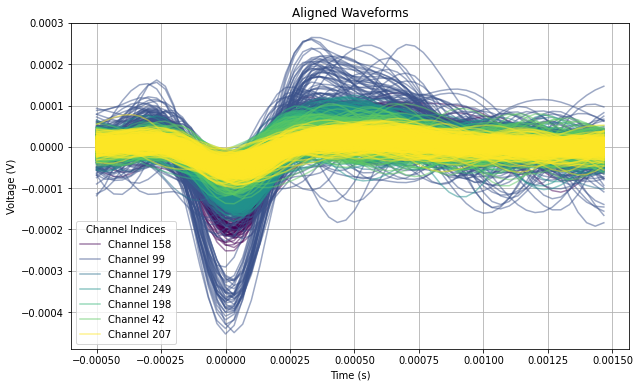

In [71]:
# List to store aligned waveforms and their mean minimum voltages
waveforms_aligned = []
channel_mean_min_voltages = []

viridis2 = ['#440154', '#3b528b', '#2d708e', '#21918c', '#35b779', '#5dc863', '#fde725']

# Iterate through selected filtered channels
for i, index in enumerate(good_waveform_indices):
    # Retrieve ephys and spikes data for the current index
    ephys_data = locals()[f'filt_{index}']
    spikes_data = locals()[f'spks{index}']
    
    try:
        # Extract, normalize, then align waveforms
        waveforms = extract_waveforms(ephys_data, fs, spikes_data, pre, post)
        aligned_waveforms = waveforms - np.mean(waveforms, axis=1, keepdims=True)
        waveforms_aligned.append((index, aligned_waveforms))
        
        # Calculate mean minimum voltage for the channel
        mean_min_voltage = aligned_waveforms.mean(axis=0).min()
        channel_mean_min_voltages.append((index, mean_min_voltage))
    except ValueError:
        # Handle case where data is not loaded
        print(f"No data loaded for ephys_{index}.")

# Sort channels by mean minimum voltage
channel_mean_min_voltages.sort(key=lambda x: x[1])

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the waveforms based on sorted order
for i, (index, mean_min_voltage) in enumerate(channel_mean_min_voltages):
    # Find the aligned waveforms for the current channel
    aligned_waveforms = next(w for idx, w in waveforms_aligned if idx == index)
    
    # Plot each aligned waveform with the corresponding color
    for j in range(aligned_waveforms.shape[0]):
        plt.plot(np.arange(-1 * pre, post, 1 / fs), aligned_waveforms[j], color=viridis2[i % len(viridis2)], alpha=0.5, label=f'Channel {index}' if j == 0 else None)
        
# Customize plot appearance
plt.title('Aligned Waveforms')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend(title="Channel Indices")
plt.show()


# Fig. 1 
Overlay of 2028 butterworth filtered spike waveforms extracted from 7 channels, plotted according to mean minimum voltage.

We can somewhat pick out waveforms here, but again it is very difficult to see individual units or waveform features, which is the information that we need to understand what cells were actually recorded from. If we didn't plot each channel manually (recall that the full dataset has over 300 channels!) and instead had a stack of all the waveforms, it would be impossible to sort them out or gather any information about the cell sample. Dimensionality reduction is a mathematical approach that we can use to separate out waveforms based on their features, and how similar to each other they are. We will be trying one linear approach, principal components analysis (PCA), and two common nonlinear approaches, t-SNE and UMAP, to see how waveforms are grouped differently by each technique.

# Dimensionality Reduction on Extracted Waveforms

Import additional packages required for dimensionality reduction.

In [21]:
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ContinuousColorMapper
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap
from bokeh.transform import factor_cmap

In [22]:
# Concatenate aligned waveforms into a single array
waveforms_aligned_stack = np.vstack(waveforms_aligned)

In [23]:
# Perform PCA
pca = PCA(n_components=2)
waveforms_pca = pca.fit_transform(waveforms_aligned_stack)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
waveforms_tsne = tsne.fit_transform(waveforms_aligned_stack)

# Perform UMAP
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
waveforms_umap = umap.fit_transform(waveforms_aligned_stack)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


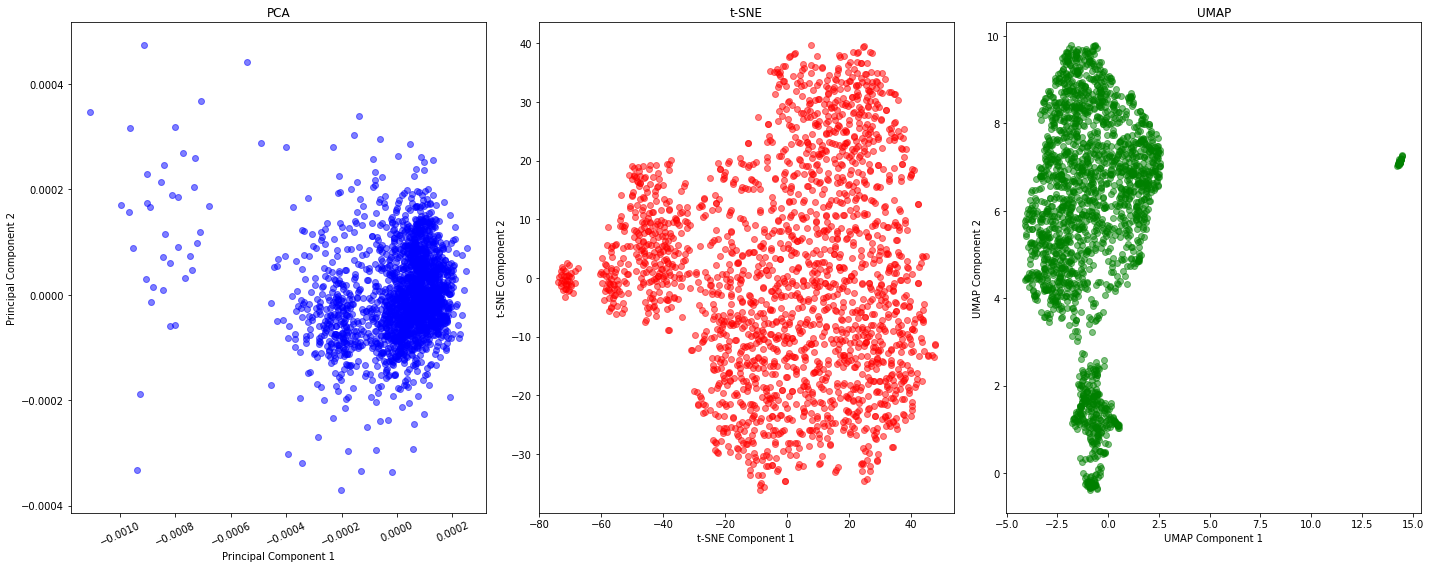

In [24]:
# Plot PCA
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.scatter(waveforms_pca[:, 0], waveforms_pca[:, 1], color='b', alpha=0.5)
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(rotation=25)

# Plot t-SNE
plt.subplot(1, 3, 2)
plt.scatter(waveforms_tsne[:, 0], waveforms_tsne[:, 1], color='r', alpha=0.5)
plt.title('t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plot UMAP
plt.subplot(1, 3, 3)
plt.scatter(waveforms_umap[:, 0], waveforms_umap[:, 1], color='g', alpha=0.5)
plt.title('UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.tight_layout()
plt.show()

After carrying out a few dimensionality reduction techniques, it seems like there has been some grouping, but it is not possible to tell where boundaries are and what data falls into which cluster. We can carry out k-means clustering, a technique that creates groups based on random iterations of regrouping based on a user-given number of clusters until optimal clustering is achieved. Let's carry out k-means clustering and see how our data is grouped within by dimensionality reduction techniqe. We will also decide how many clusters to use using an elbow plot. This computes the change in euclidean distance each time we add a cluster (we'll set the maximum number of clusters to 15 since we shouldn't have more than 15 units across our channels). When the elbow plot levels out, that is an indicator that increasing the number of clusters is no longer statistically beneficial since the groups are not getting pulled apart anymore, so we will choose our number of clusters based on that.

In [25]:
#function to carry out k-means clustering on each dimred projection with n of 10
def k_means(data, num_clus=10, steps=500):

    # Convert data to Numpy array
    cluster_data = np.array(data)

    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))

            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())

    return cluster, center_init, distance

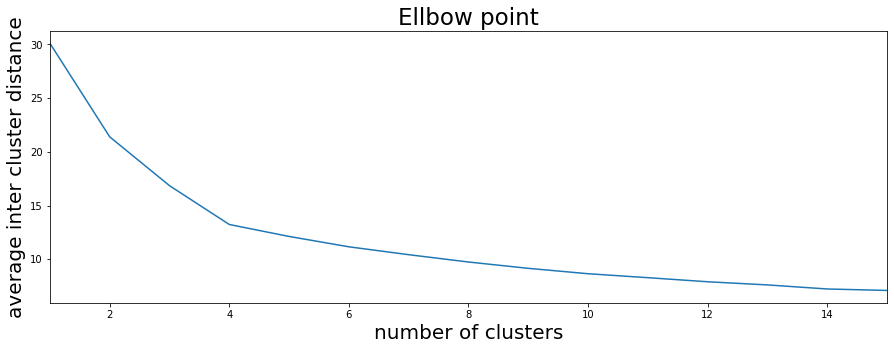

In [26]:
#we can use an elbow point to identify an optimal amount of clusters based on the results of the tSNE.
#computationally intensive readout - don't need to run 
max_num_clusters = 15

average_distance = []
for run in range(20):
    tmp_average_distance = []
    for num_clus in range(1, max_num_clusters +1):
        cluster, centers, distance = k_means(waveforms_tsne, num_clus)
        tmp_average_distance.append(np.mean([np.mean(distance[x][cluster==x]) for x in range(num_clus)], axis=0))
    average_distance.append(tmp_average_distance)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(1, max_num_clusters +1), np.mean(average_distance, axis=0))
ax.set_xlim([1, max_num_clusters])
ax.set_xlabel('number of clusters', fontsize=20)
ax.set_ylabel('average inter cluster distance', fontsize=20)
ax.set_title('Elbow point', fontsize=23)
plt.show()

Okay, so it looks like around 8 clusters is where the elbow point begins to level out. This means that adding more clusters won't be very beneficial because the euclidean distance between the clusters is already as optimal as we will get. So let's stick to using n=10 for our k-means. However, because we know that we should have at least as many cells as good channels, we will apply a more liberal clustering selection and choose 10 clusters, because we would rather separate two cells that are the same than average two units that are not from the same cell because this could distort their waveforms and affect metrics like amplitude leading to us potentially conflating the cell types present in our sample.

We are using K-means for accessibility purposes - unsupervised clustering models often require dependencies and resources are less prominent online, but k-means algorithms are widely used and documented within science. Unfortunately, using a supervised clustering model is forcing us to estimate the true number of units present in our sample before we actually sort the data. However, upon analysis the number of clusters can always be adjusted, for example if we see multiple units getting grouped together or very similar data from the same channel getting split up into more than one cluster repeatedly. Spike sorting typically requires some manual post-processing. 

In [27]:
#set param of clusters equal to 10, based on elbow point.
num_clusts = 10

In [79]:
def plot_waveforms_in_subplots(cluster, projection_name):
    time = np.linspace(0, waveforms_aligned_stack.shape[1] / fs, waveforms_aligned_stack.shape[1]) * 1000
    fig, axs = plt.subplots(2, 5, figsize=(25, 10), sharex=True)
    fig.suptitle(f'Extracted Waveforms Based on {projection_name} Projection', fontsize=25)
    axs = axs.ravel()
    
    # Calculate the minimum voltage of the mean waveform for each cluster
    cluster_min_voltages = []
    for i in range(num_clusts):
        cluster_waveforms = waveforms_aligned_stack[cluster == i, :]
        cluster_mean = cluster_waveforms.mean(axis=0)
        min_voltage = cluster_mean.min()
        cluster_min_voltages.append((i, min_voltage))
    
    # Sort clusters by minimum voltage
    cluster_min_voltages.sort(key=lambda x: x[1])
    
    for plot_idx, (cluster_idx, min_voltage) in enumerate(cluster_min_voltages):
        cluster_waveforms = waveforms_aligned_stack[cluster == cluster_idx, :]
        cluster_mean = cluster_waveforms.mean(axis=0)
        cluster_std = cluster_waveforms.std(axis=0)
        
        for waveform in cluster_waveforms:
            axs[plot_idx].plot(time, waveform, color=colors[plot_idx], alpha=0.3)
        axs[plot_idx].plot(time, cluster_mean, color='black', linewidth=2)
        axs[plot_idx].set_title(f'Potential unit {cluster_idx + 1}')
        axs[plot_idx].set_xlabel('Time [ms]')
        axs[plot_idx].set_ylabel('Amplitude [uV]')
        
        # Scale axes based on 1.5 times the range of the waveforms
        min_ax_voltage = cluster_waveforms.min()
        max_ax_voltage = cluster_waveforms.max()
        range_voltage = max_ax_voltage - min_ax_voltage
        axs[plot_idx].set_ylim([min_ax_voltage - 0.25 * range_voltage, max_ax_voltage + 0.25 * range_voltage])
        
        # Display standard deviation in scientific notation
        std_dev_text = f'N Waveforms: {cluster_waveforms.shape[0]}\nStd Dev: {cluster_std.mean():.2e}'
        axs[plot_idx].legend([std_dev_text], loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


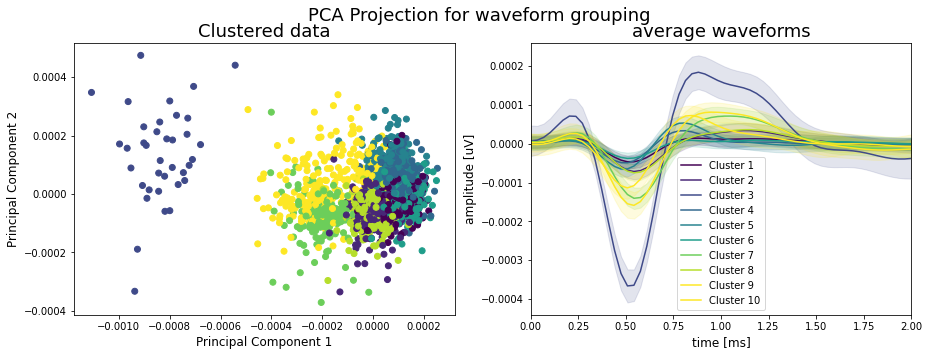

In [75]:
#carry out kmeans for PCA
cluster, centers, distance = k_means(waveforms_pca, num_clusts)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('PCA Projection for waveform grouping', fontsize=18)
ax[0].scatter(waveforms_pca[:, 0], waveforms_pca[:, 1], c=[viridis_colors[i] for i in cluster])
ax[0].set_xlabel('Principal Component 1', fontsize=12)
ax[0].set_ylabel('Principal Component 2', fontsize=12)
ax[0].set_title('Clustered data', fontsize=18)

# Plot average waveforms for each cluster
time = np.linspace(0, waveforms_aligned_stack.shape[1] / fs, waveforms_aligned_stack.shape[1]) * 1000
for i in range(num_clusts):
    cluster_waveforms = waveforms_aligned_stack[cluster == i, :]
    cluster_mean = cluster_waveforms.mean(axis=0)
    cluster_std = cluster_waveforms.std(axis=0)

    ax[1].plot(time, cluster_mean, color=viridis_colors[i], label='Cluster {}'.format(i + 1))
    ax[1].fill_between(time, cluster_mean - cluster_std, cluster_mean + cluster_std, color=viridis_colors[i], alpha=0.15)

ax[1].set_title('average waveforms', fontsize=18)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('amplitude [uV]', fontsize=12)

plt.legend()
plt.show()


## Fig. 2a, b
K-means clustering carried out on principal components and corresponding waveforms plotted as an average based on clustering.

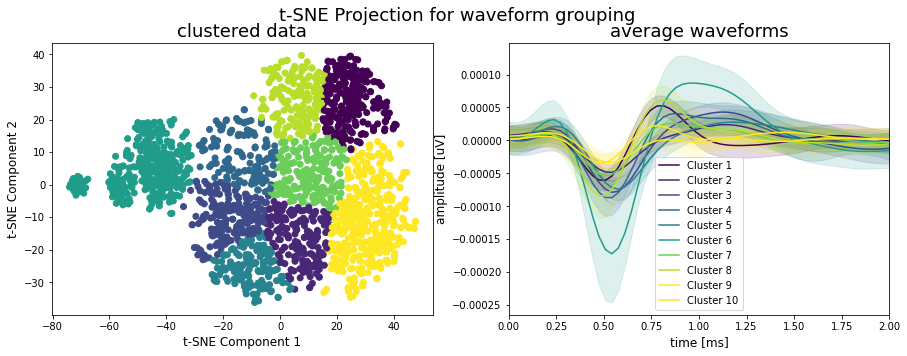

In [30]:
#Repeat for t-SNE
cluster, centers, distance = k_means(waveforms_tsne, num_clusts)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('t-SNE Projection for waveform grouping', fontsize=18)
ax[0].scatter(waveforms_tsne[:, 0], waveforms_tsne[:, 1], c=[viridis_colors[i] for i in cluster])
ax[0].set_xlabel('t-SNE Component 1', fontsize=12)
ax[0].set_ylabel('t-SNE Component 2', fontsize=12)
ax[0].set_title('clustered data', fontsize=18)

# Plot average waveforms for each cluster
time = np.linspace(0, waveforms_aligned_stack.shape[1] / fs, waveforms_aligned_stack.shape[1]) * 1000
for i in range(num_clusts):
    cluster_waveforms = waveforms_aligned_stack[cluster == i, :]
    cluster_mean = cluster_waveforms.mean(axis=0)
    cluster_std = cluster_waveforms.std(axis=0)

    ax[1].plot(time, cluster_mean, color=viridis_colors[i], label='Cluster {}'.format(i + 1))
    ax[1].fill_between(time, cluster_mean - cluster_std, cluster_mean + cluster_std, color=viridis_colors[i], alpha=0.15)

ax[1].set_title('average waveforms', fontsize=18)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('amplitude [uV]', fontsize=12)

plt.legend()
plt.show()

## Fig. 2c, d
K-means clustering carried out on t-SNE and corresponding waveforms plotted as an average based on clustering.

In [31]:
#repeat for UMAP
cluster, centers, distance = k_means(waveforms_umap, num_clusts)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('UMAP Projection for waveform grouping', fontsize=18)
ax[0].scatter(waveforms_umap[:, 0], waveforms_umap[:, 1], c=[viridis_colors[i] for i in cluster])
ax[0].set_xlabel('UMAP Component 1', fontsize=12)
ax[0].set_ylabel('UMAP Component 2', fontsize=12)
ax[0].set_title('clustered data', fontsize=18)

# Plot average waveforms for each cluster
time = np.linspace(0, waveforms_aligned_stack.shape[1] / fs, waveforms_aligned_stack.shape[1]) * 1000
for i in range(num_clusts):
    umap_cluster_waveforms = waveforms_aligned_stack[cluster == i, :]
    umap_cluster_mean = umap_cluster_waveforms.mean(axis=0)
    umap_cluster_std = umap_cluster_waveforms.std(axis=0)

    ax[1].plot(time, umap_cluster_mean, color=viridis_colors[i], label='Cluster {}'.format(i + 1))
    ax[1].fill_between(time, umap_cluster_mean - umap_cluster_std, umap_cluster_mean + umap_cluster_std, color=viridis_colors[i], alpha=0.15)

ax[1].set_title('average waveforms', fontsize=18)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('amplitude [uV]', fontsize=12)

plt.legend()
plt.show()

## Fig. 2e, f
K-means clustering carried out on UMAP projection and corresponding waveforms plotted as an average based on clustering.

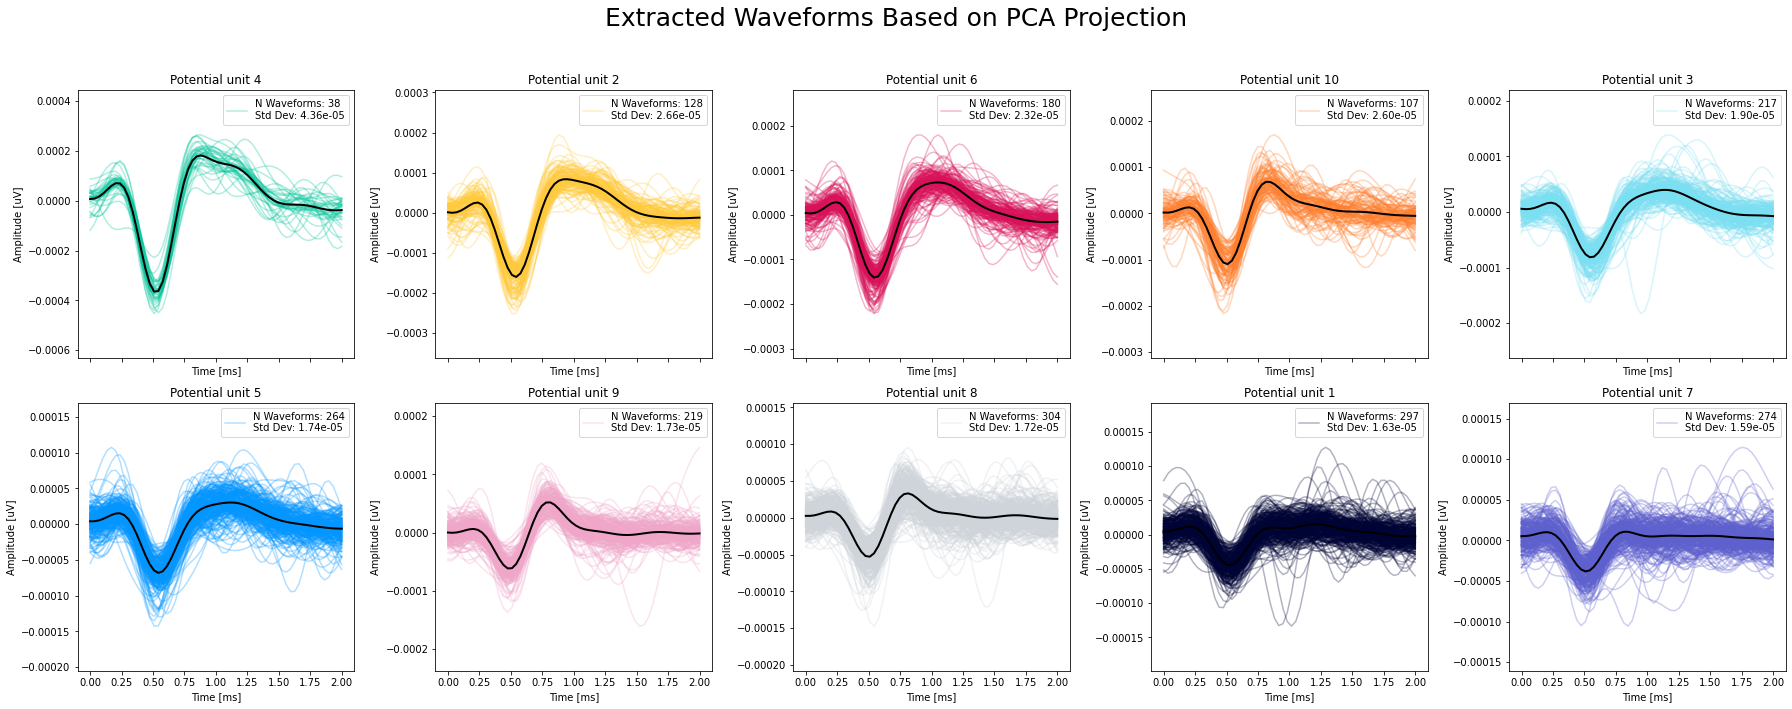

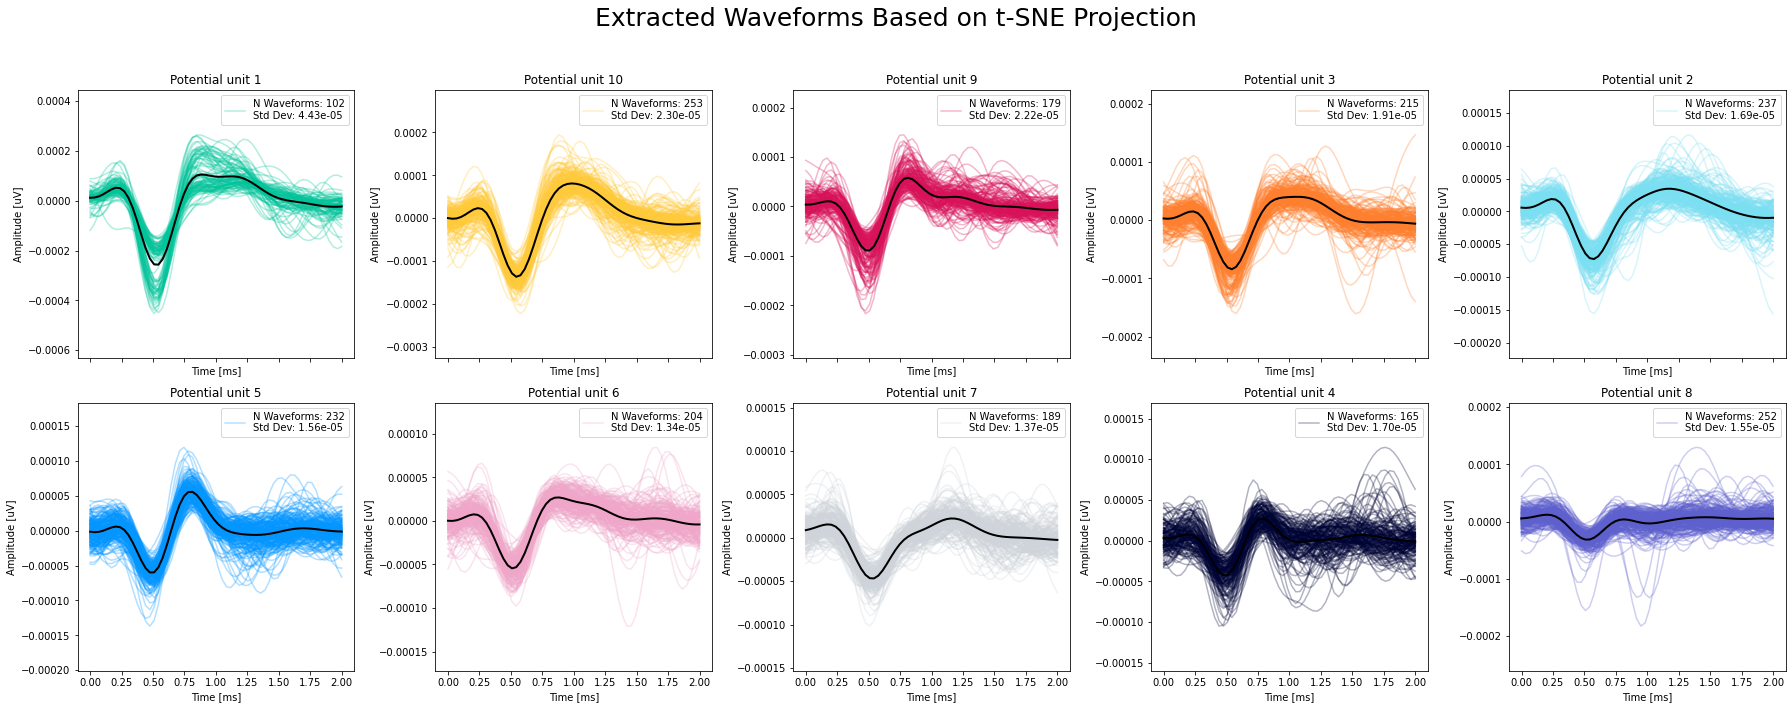

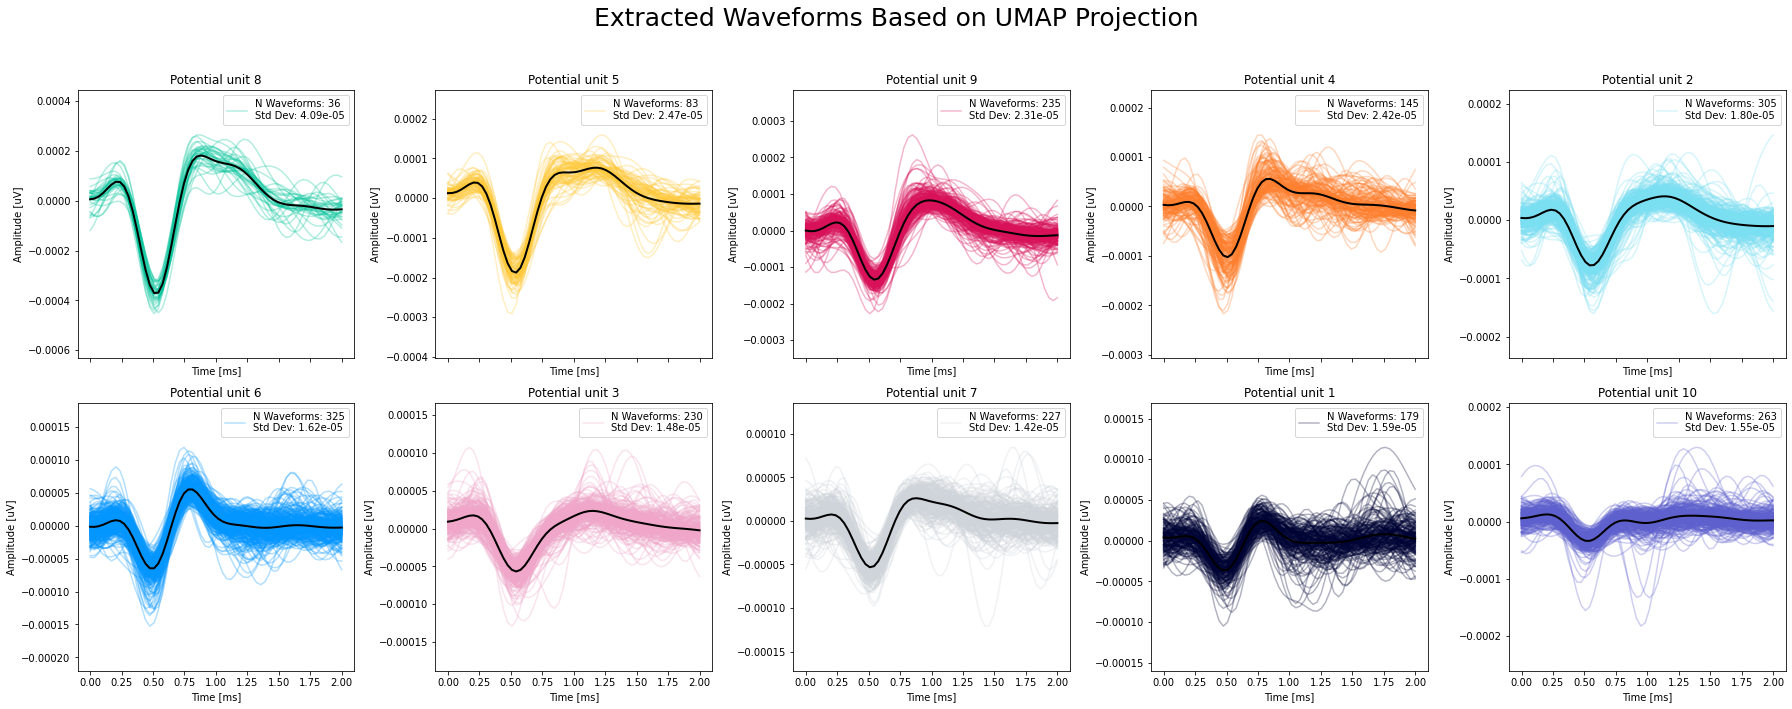

In [80]:
# Perform k-means clustering on each projection and plot waveforms according to their kmeans cluster rather than their channel
num_clusts = 10

plot_waveforms_in_subplots(cluster_pca, 'PCA')
plot_waveforms_in_subplots(cluster_tsne, 't-SNE')
plot_waveforms_in_subplots(cluster_umap, 'UMAP')

# Fig. 3 a, b, c
Waveforms grouped based by k-means clustering applied to PCA (3a), t-SNE (3b), and UMAP (3c) dimensionality reduction projections. Subplots are ordered based on the minimum voltage of the waveform while the potential unit index refers to the cluster. Note that clusters are reselected each time K-means is carried out so these indices are somewhat arbitrary.

In [33]:
# Calculate and print standard deviations for PCA
std_devs_pca = []
for i in range(num_clusts):
    pca_cluster_waveforms = waveforms_aligned_stack[cluster_pca == i, :]
    pca_cluster_std = pca_cluster_waveforms.std(axis=0)
    std_devs_pca.append(pca_cluster_std.mean())
    print(f'PCA Cluster {i + 1} Standard Deviation: {pca_cluster_std.mean():.2e} uV')
mean_std_dev_pca = np.mean(std_devs_pca)
print(f'Mean Standard Deviation for PCA: {mean_std_dev_pca:.2e} uV')

# Calculate and print standard deviations for t-SNE
std_devs_tsne = []
for i in range(num_clusts):
    tsne_cluster_waveforms = waveforms_aligned_stack[cluster_tsne == i, :]
    tsne_cluster_std = tsne_cluster_waveforms.std(axis=0)
    std_devs_tsne.append(tsne_cluster_std.mean())
    print(f't-SNE Cluster {i + 1} Standard Deviation: {tsne_cluster_std.mean():.2e} uV')
mean_std_dev_tsne = np.mean(std_devs_tsne)
print(f'Mean Standard Deviation for t-SNE: {mean_std_dev_tsne:.2e} uV')

# Calculate and print standard deviations for UMAP
std_devs_umap = []
for i in range(num_clusts):
    umap_cluster_waveforms = waveforms_aligned_stack[cluster_umap == i, :]
    umap_cluster_std = umap_cluster_waveforms.std(axis=0)
    std_devs_umap.append(umap_cluster_std.mean())
    print(f'UMAP Cluster {i + 1} Standard Deviation: {umap_cluster_std.mean():.2e} uV')
mean_std_dev_umap = np.mean(std_devs_umap)
print(f'Mean Standard Deviation for UMAP: {mean_std_dev_umap:.2e} uV')

PCA Cluster 1 Standard Deviation: 1.63e-05 uV
PCA Cluster 2 Standard Deviation: 2.66e-05 uV
PCA Cluster 3 Standard Deviation: 1.90e-05 uV
PCA Cluster 4 Standard Deviation: 4.36e-05 uV
PCA Cluster 5 Standard Deviation: 1.74e-05 uV
PCA Cluster 6 Standard Deviation: 2.32e-05 uV
PCA Cluster 7 Standard Deviation: 1.59e-05 uV
PCA Cluster 8 Standard Deviation: 1.72e-05 uV
PCA Cluster 9 Standard Deviation: 1.73e-05 uV
PCA Cluster 10 Standard Deviation: 2.60e-05 uV
Mean Standard Deviation for PCA: 2.22e-05 uV
t-SNE Cluster 1 Standard Deviation: 4.43e-05 uV
t-SNE Cluster 2 Standard Deviation: 1.69e-05 uV
t-SNE Cluster 3 Standard Deviation: 1.91e-05 uV
t-SNE Cluster 4 Standard Deviation: 1.70e-05 uV
t-SNE Cluster 5 Standard Deviation: 1.56e-05 uV
t-SNE Cluster 6 Standard Deviation: 1.34e-05 uV
t-SNE Cluster 7 Standard Deviation: 1.37e-05 uV
t-SNE Cluster 8 Standard Deviation: 1.55e-05 uV
t-SNE Cluster 9 Standard Deviation: 2.22e-05 uV
t-SNE Cluster 10 Standard Deviation: 2.30e-05 uV
Mean Standard

Above are waveforms sorted into 10 clusters dictated by k-means clustering onto our PCA, t-SNE, and UMAP projections. Note that cluster centers are chosen randomly each time by the k-means algorithm so each time this is run the cluster order will be different, there may also be slight changes in waveform groupings due to this.

We can see some differences, especially in the way that t-SNE grouped its first cluster as one potential unit (using the index of the waveform we can check and see that this is channel 99). This appears to be 2 units, but t-SNE is the only model that did not separate them. We can actually see this in the t-SNE projection as well. Cluster 4 of the umap projection also seems like it could have two units on it. It also pulls apart the small cluster in the corner, corresponding to potential unit 1 much more than PCA and t-SNE do - we can see by looking at the t-SNE results that our t-SNE model actually grouped this data together while UMAP drastically separated it. And if in reality there had been only 8 or 9 cells, this model would have falsely separated waveforms from the same cell in order to cluster our waveform data into 10 groups like we asked it to. 

So what if we don't know how many cells we have? We can implement an unsupervised technique, such as DBSCAN or heirarchical clustering to optimally identify the cluster number and cluster data points accordingly. However, these are computationally intensive to run on millions of numbers like we have in our data and require dependencies as opposed to k-means, which can be carried out with a simple function and is thoroughly documented.

# Implementation of dimensionality reduction on data from Lee et al. as proof of concept of this technique for spike classification.

WaveMAP has been used primarily for classification of cell types from presorted and normalized data, whereas our technique applies similar ideas to unaveraged raw recordings. We aim to see if this is a valid method for grouping cells and whether it performs similarly to WaveMAP. First, let's load in our data and see what we have. This is preprocessed data that was taken from a recording in a primate premotor cortex and features 625 waveforms, each representing averaged spikes from a single cell. The data has already been spike sorted, averaged, and normalized. Used in two publications from Kenji Lee, one is a methods paper detailing WaveMAP, and the other details WaveMAP's usage for identification of cell types in the primate premotor cortex. Because our data features individual spikes from 7 channels - presumably representing 5-15 individual cells - we aim to see whether our technique performs similarly to WaveMAP to broadly identify cell types in addition to single units. (Lee et al., 2023)

In [46]:
#load data
full_data = np.load('full_data.npy')

#SET PARAMS
#These are the depths that the V-probe channels are located at
DEPTHS = [0.15,0.3,0.45,0.60,0.75,0.9,1.05,1.20,1.35,1.50,1.65,1.80,1.95,2.1,2.25,2.4]

#This converts time points to real time. There are 48 samples per waveform colleted at 30 kilosamples
SAMP_RATE_TO_TIME = 1/(48/30000) 

#Setting of random seed across Python kernel and packages to ensure reproducibility 
RAND_STATE=42
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

#UMAP Parameters
#The number of neighbors considered when constructing the high-d graph. 
#Made more global-information preserving by increasing it from 15 to 20.
N_NEIGHBORS = 20 

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.1

#Louvain Clustering Parameters
RESOLUTION = 1.5

Plotting: 625 Waveforms


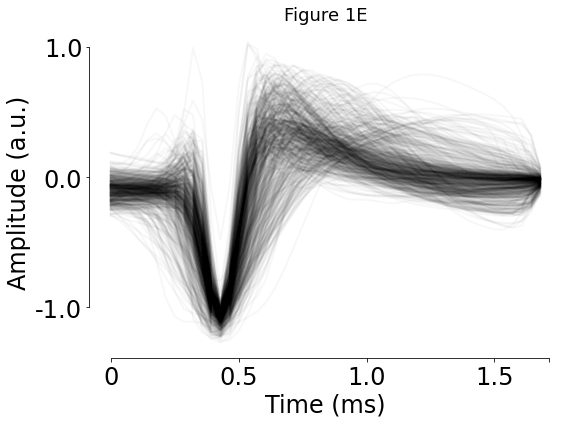

In [39]:
# This plots all the normalized single unit waveforms together. The total waveform length is 48 points at 30000 samples/s
# 14, 28, 42 are the 0.5 ms, 1.0 ms, and 1.5 ms

# Generate subplots
f, arr = plt.subplots(1,figsize=[8,6])

print(BlueCol + "Plotting: " + str(full_data.shape[0]) + " Waveforms")
for i in range(0,full_data.shape[0]):
    arr.plot(full_data[i].T, c = 'k', alpha = 0.03,linewidth=2.);
    
arr.tick_params(direction='out',colors='k', axis='both')
    
# Set various x and y axes and labels etc.
arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)

arr.spines['left'].set_bounds(-1,1)
arr.spines['bottom'].set_bounds(0,48)

arr.set_xlabel('Time (ms)', fontsize=24);
arr.set_xticks([0,14,28,42,48])
arr.set_xticklabels(['0','0.5','1.0','1.5',''],fontsize=24)

arr.set_ylabel('Amplitude (a.u.)', fontsize=24)
arr.set_yticks([-1.0,0.0,1.0]);
arr.set_yticklabels([-1.0,0.0,1.0], fontsize=24);

# Plot the data
plt.tight_layout()

In [40]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_data)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(full_data)

# Perform UMAP
umap_model = UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(full_data)

/opt/conda/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


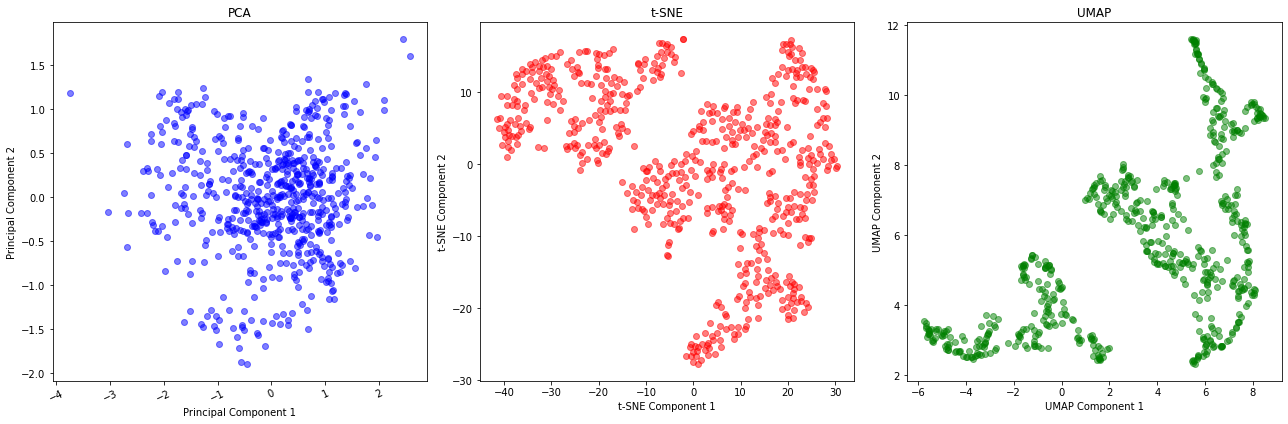

In [41]:
# Plot PCA
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='b', alpha=0.5)
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xticks(rotation=25)

# Plot t-SNE
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], color='r', alpha=0.5)
plt.title('t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plot UMAP
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1], color='g', alpha=0.5)
plt.title('UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.tight_layout()
plt.show()

Now we have performed dimensionality reduction on the averaged waveforms that were used for WaveMAP. Let's cluster them and see what they look like once separated by the k-means algorithm! But first, we need to decide how many clusters to use, i.e., predict how many cell types are present in our data. We will do this using UMAP because WaveMAP utilizes UMAP to cluster cells and dictate . Recall that now, a cluster should indicate a group or subtype of cells, whereas before it represented waveforms that belonged to the same cell. 

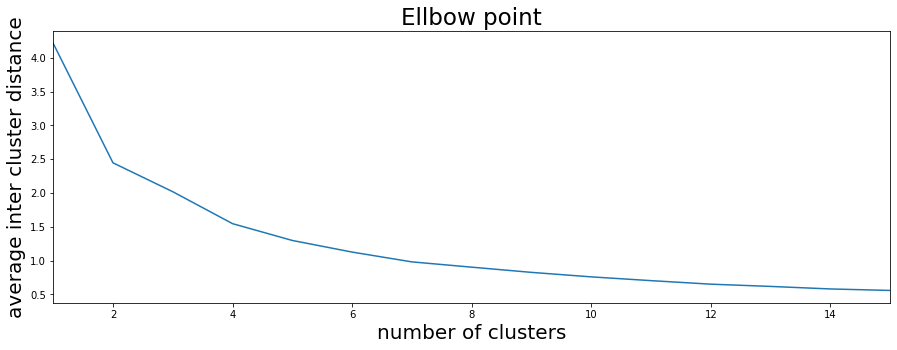

In [42]:
#we can use an elbow point to identify an optimal amount of clusters based on the results of the UMAP.
#this cell takes a long time to run and is just a readout - don't need to run it every time.
max_num_clusters = 15

average_distance = []
for run in range(20):
    tmp_average_distance = []
    for num_clus in range(1, max_num_clusters +1):
        cluster, centers, distance = k_means(umap_result, num_clus)
        tmp_average_distance.append(np.mean([np.mean(distance[x][cluster==x]) for x in range(num_clus)], axis=0))
    average_distance.append(tmp_average_distance)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(1, max_num_clusters +1), np.mean(average_distance, axis=0))
ax.set_xlim([1, max_num_clusters])
ax.set_xlabel('number of clusters', fontsize=20)
ax.set_ylabel('average inter cluster distance', fontsize=20)
ax.set_title('Elbow point', fontsize=23)
plt.show()

The plot seems to be level around 8 clusters using a more liberal selection criteria. Let's use num_clust = 8 - so for this example we predict there to be 8 cell types.

In [49]:
num_clus = 8
# Perform clustering on PCA
pca_clusters, pca_centers, pca_distance = k_means(pca_result, num_clus)

# Perform clustering on t-SNE
tsne_clusters, tsne_centers, tsne_distance = k_means(tsne_result, num_clus)

# Perform clustering on UMAP
umap_clusters, umap_centers, umap_distance = k_means(umap_result, num_clus)

In [59]:
def plot_fulldata_subplots(cluster, projection_name):
    time = np.linspace(0, full_data.shape[1] / fs, full_data.shape[1]) * 1000
    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
    fig.suptitle(f'Extracted Waveforms Based on {projection_name} Projection', fontsize=25)
    axs = axs.ravel()
    
    # Calculate the minimum voltage of the mean waveform for each cluster
    cluster_min_voltages = []
    for i in range(num_clus):
        cluster_waveforms = full_data[cluster == i, :]
        cluster_mean = cluster_waveforms.mean(axis=0)
        min_voltage = cluster_mean.min()
        cluster_min_voltages.append((i, min_voltage))
    
    # Sort clusters by minimum voltage
    cluster_min_voltages.sort(key=lambda x: x[1])
    
    # Plot the waveforms based on the sorted order
    for plot_idx, (cluster_idx, min_voltage) in enumerate(cluster_min_voltages):
        cluster_waveforms = full_data[cluster == cluster_idx, :]
        cluster_mean = cluster_waveforms.mean(axis=0)
        cluster_std = cluster_waveforms.std(axis=0)
        
        for waveform in cluster_waveforms:
            axs[plot_idx].plot(time, waveform, color=colors[cluster_idx % len(colors)], alpha=0.3)
        axs[plot_idx].plot(time, cluster_mean, color='black', linewidth=2)
        axs[plot_idx].set_title(f'Potential unit {cluster_idx + 1}')
        axs[plot_idx].set_xlabel('Time [ms]')
        axs[plot_idx].set_ylabel('Amplitude [uV]')
        axs[plot_idx].legend([f'N Waveforms: {cluster_waveforms.shape[0]}\nStd Dev: {cluster_std.mean():.2f}'], loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

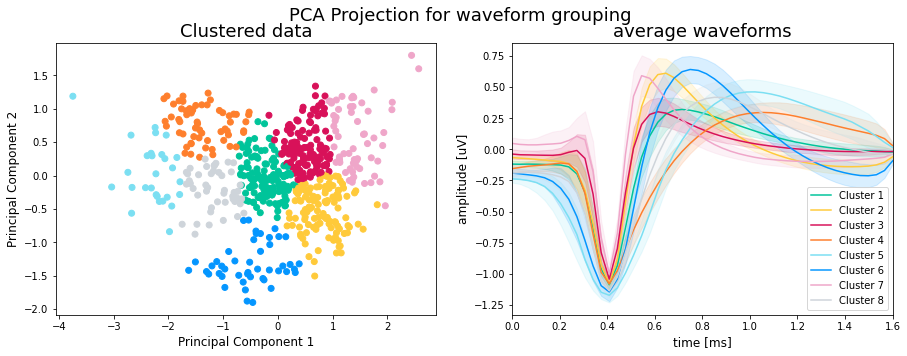

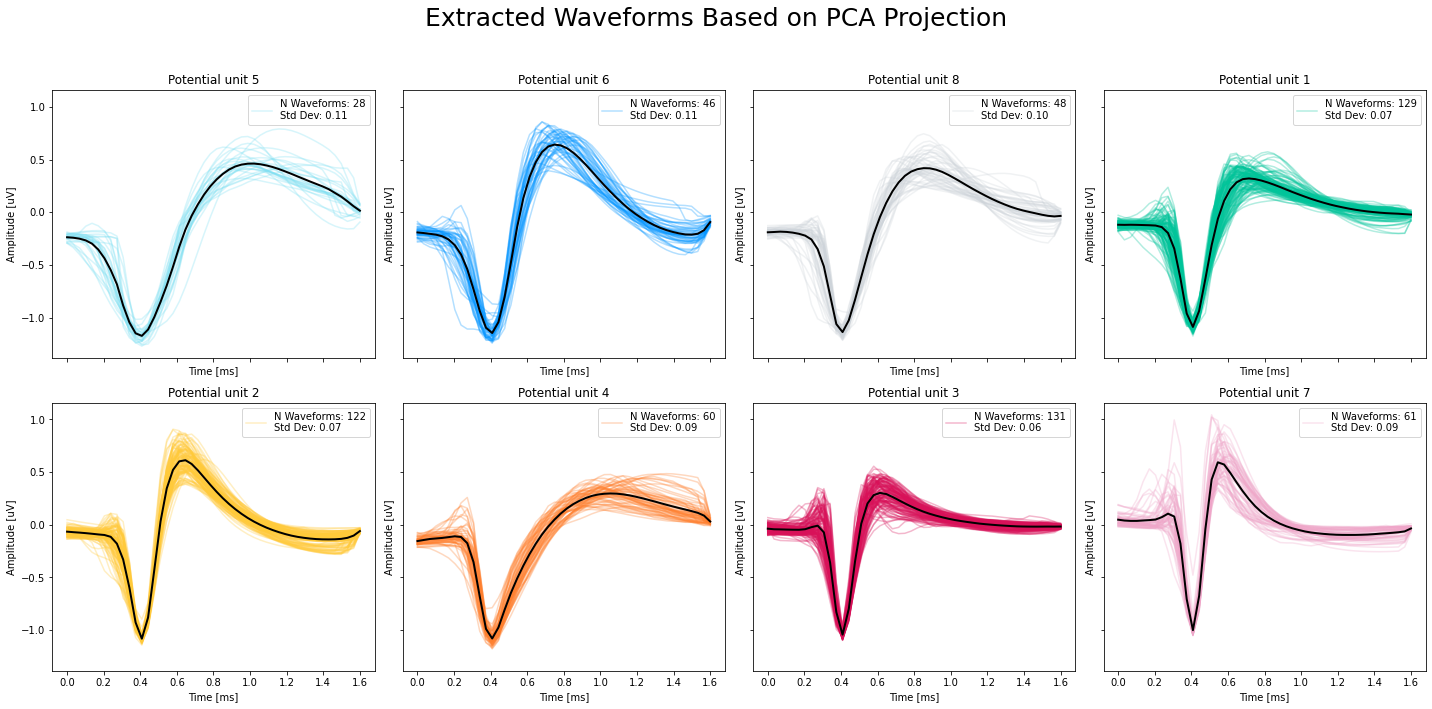

In [60]:
cluster_colors = ['#00c49a', '#ffca3a', '#D81159', '#fe7f2d', '#7bdff2', '#0496ff', '#efa6c9', '#ced4da', '#000435','#5e60ce']

# Plot the result for PCA
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('PCA Projection for waveform grouping', fontsize=18)
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=[cluster_colors[i] for i in pca_clusters])
ax[0].set_xlabel('Principal Component 1', fontsize=12)
ax[0].set_ylabel('Principal Component 2', fontsize=12)
ax[0].set_title('Clustered data', fontsize=18)

# Plot average waveforms for each cluster
time = np.linspace(0, full_data.shape[1] / fs, full_data.shape[1]) * 1000
for i in range(num_clus):
    cluster_waveforms = full_data[pca_clusters == i, :]
    cluster_mean = cluster_waveforms.mean(axis=0)
    cluster_std = cluster_waveforms.std(axis=0)

    ax[1].plot(time, cluster_mean, color=cluster_colors[i], label='Cluster {}'.format(i + 1))
    ax[1].fill_between(time, cluster_mean - cluster_std, cluster_mean + cluster_std, color=cluster_colors[i], alpha=0.15)

ax[1].set_title('average waveforms', fontsize=18)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('amplitude [uV]', fontsize=12)

plt.legend()
plt.show()

#carry out kmeans for PCA
cluster, centers, distance = k_means(waveforms_pca, num_clusts)

plot_fulldata_subplots(pca_clusters, 'PCA')

## Fig. 4 a, b, c: PCA projection with K-means clustering (4a), averaged waveforms based on clusters (4b), waveforms grouped by PCA projection (4c)

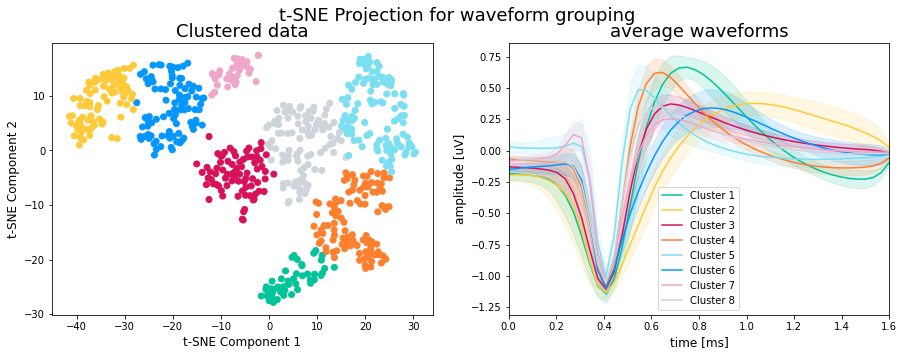

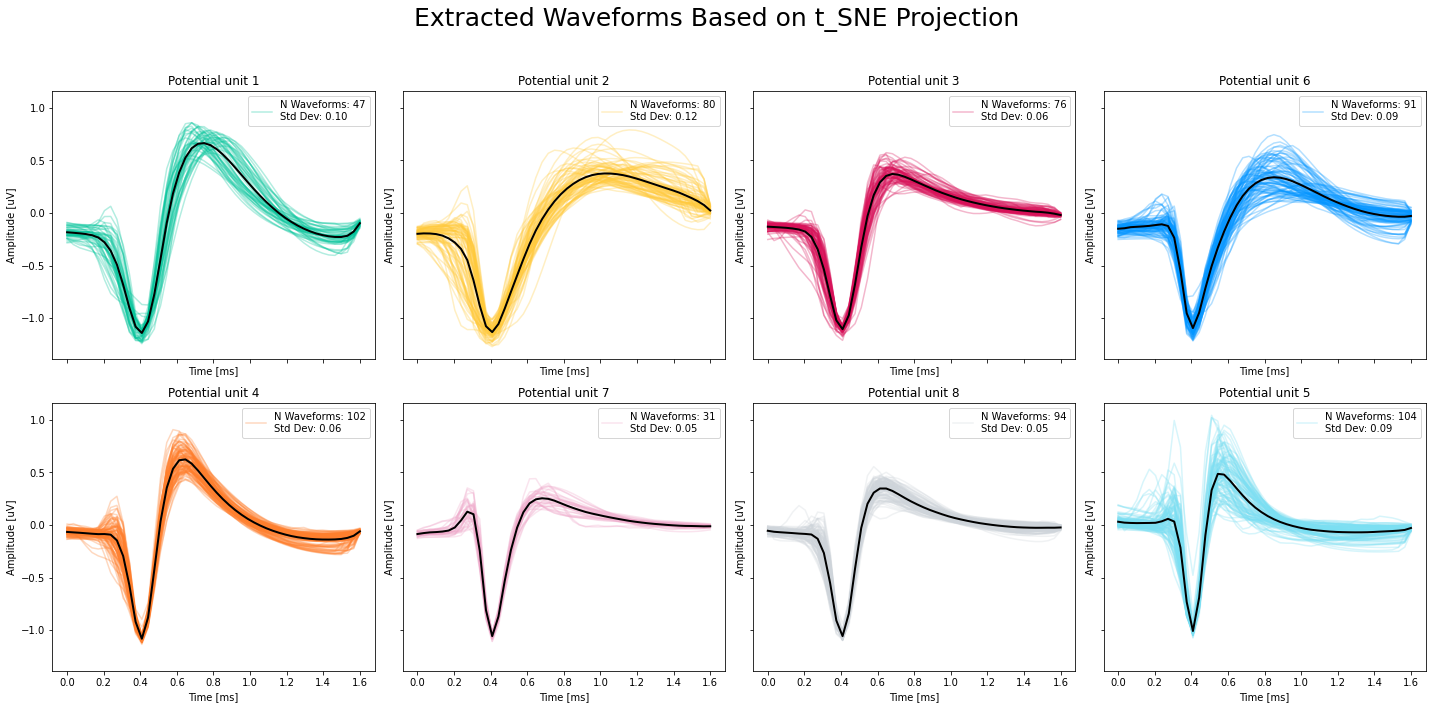

In [61]:
#carry out kmeans for t-SNE
num_clus = 8
cluster, centers, distance = k_means(tsne_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('t-SNE Projection for waveform grouping', fontsize=18)
ax[0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=[cluster_colors[i] for i in tsne_clusters])
ax[0].set_xlabel('t-SNE Component 1', fontsize=12)
ax[0].set_ylabel('t-SNE Component 2', fontsize=12)
ax[0].set_title('Clustered data', fontsize=18)

# Plot average waveforms for each cluster
time = np.linspace(0, full_data.shape[1] / fs, full_data.shape[1]) * 1000
for i in range(num_clus):
    cluster_waveforms = full_data[tsne_clusters == i, :]
    cluster_mean = cluster_waveforms.mean(axis=0)
    cluster_std = cluster_waveforms.std(axis=0)

    ax[1].plot(time, cluster_mean, color=cluster_colors[i], label='Cluster {}'.format(i + 1))
    ax[1].fill_between(time, cluster_mean - cluster_std, cluster_mean + cluster_std, color=cluster_colors[i], alpha=0.15)

ax[1].set_title('average waveforms', fontsize=18)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('amplitude [uV]', fontsize=12)

plt.legend()
plt.show()

plot_fulldata_subplots(tsne_clusters, 't_SNE')

## Fig. 5 a, b, c: t-SNE projection with K-means clustering (5a), averaged waveforms based on clusters (5b), waveforms grouped by t-SNE projection (5c)

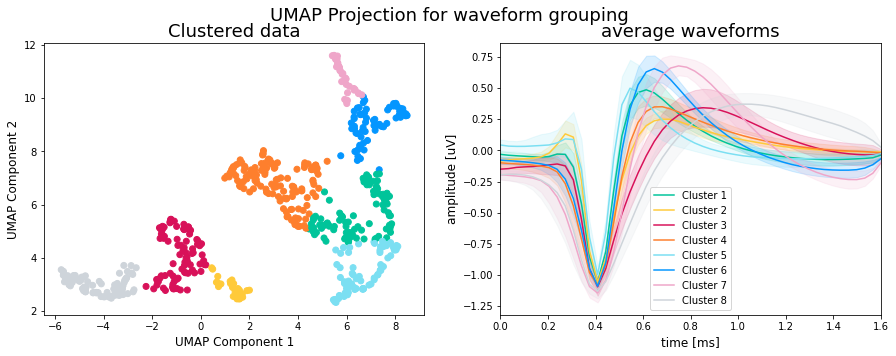

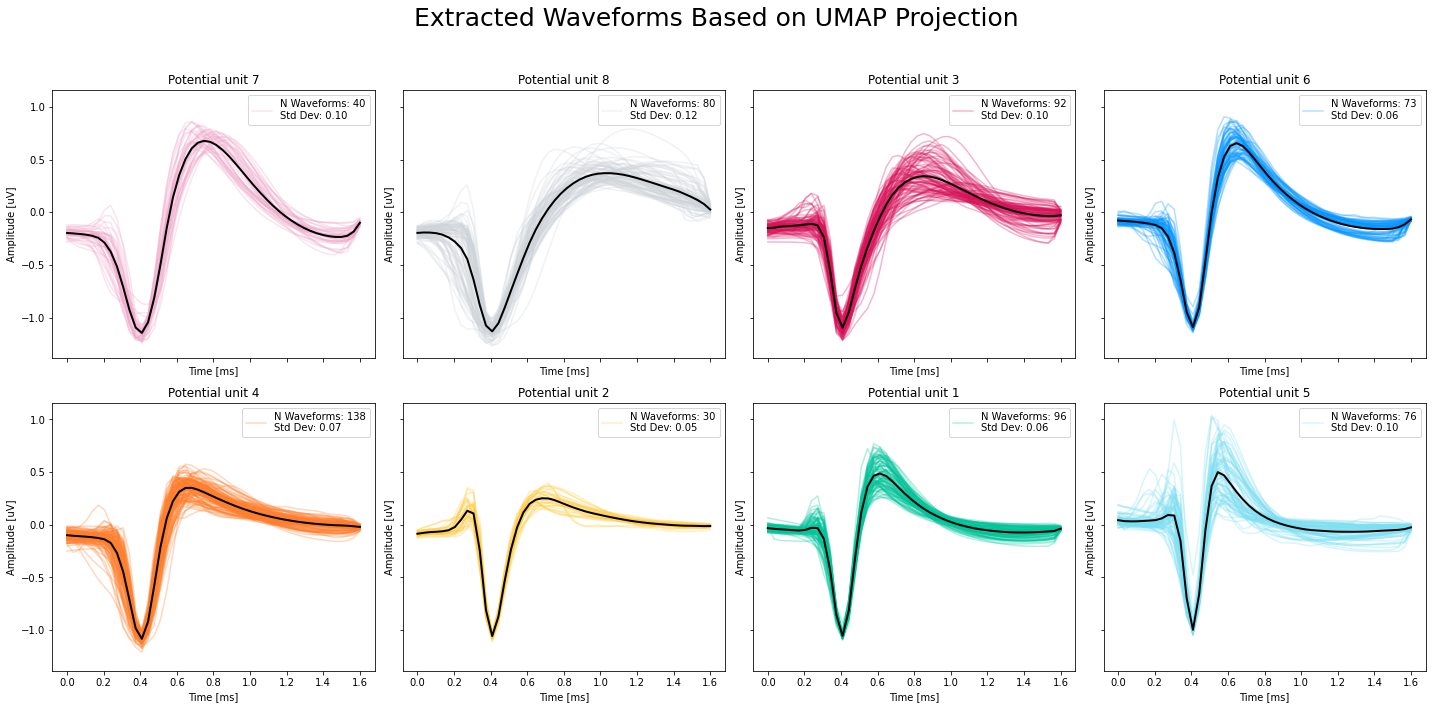

In [62]:
#carry out kmeans for UMAP
num_clus = 8
cluster, centers, distance = k_means(umap_result, num_clus)

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('UMAP Projection for waveform grouping', fontsize=18)
ax[0].scatter(umap_result[:, 0], umap_result[:, 1], c=[cluster_colors[i] for i in umap_clusters])
ax[0].set_xlabel('UMAP Component 1', fontsize=12)
ax[0].set_ylabel('UMAP Component 2', fontsize=12)
ax[0].set_title('Clustered data', fontsize=18)

# Plot average waveforms for each cluster
time = np.linspace(0, full_data.shape[1] / fs, full_data.shape[1]) * 1000
for i in range(num_clus):
    cluster_waveforms = full_data[umap_clusters == i, :]
    cluster_mean = cluster_waveforms.mean(axis=0)
    cluster_std = cluster_waveforms.std(axis=0)

    ax[1].plot(time, cluster_mean, color=cluster_colors[i], label='Cluster {}'.format(i + 1))
    ax[1].fill_between(time, cluster_mean - cluster_std, cluster_mean + cluster_std, color=cluster_colors[i], alpha=0.15)

ax[1].set_title('average waveforms', fontsize=18)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('amplitude [uV]', fontsize=12)

plt.legend()
plt.show()

plot_fulldata_subplots(umap_clusters, 'UMAP')

## Fig. 6 a, b, c: UMAP projection with K-means clustering (6a), averaged waveforms based on clusters (6b), waveforms grouped by UMAP projection (6c)

It seems like the elbow plot and k-means did a pretty good job of identifying the same clusters that louvain community detection did in WaveMAP on our UMAP projection. It also seems there are a few differences, which we can see in the clustering results and the number of cells sorted into each cluster. Note that each dimensionality reduction technique's clusters that appear to be the same unit have slightly different numbers of waveforms grouped into that cluster.

# Discussion

In our study, we utilized three dimensionality reduction techniques: PCA, UMAP, t-SNE, and implemented k-means clustering for waveform grouping based on feature similarity. We then compared our method to results obtained using the WaveMAP method, using the data provided in Lee et al., 2023. Our technique showed clearer clustering when using averaged waveforms compared to raw data, but offers promising applications for spike sorting raw data while maintaining waveform characteristics as well.

Our tool has two demonstrated applications: When implemented on spike waveforms from multiple channels from a raw electrophysiological recording, it can be used as a spike sorting tool and subsequently to identify cell types present in the recording. When implemented on many normalized averaged spikes (each from a single cell), it can group cells in a population based on features of their waveforms which can indicate their cell type. Cell subpopulations can be identified more clearly by using data that has already averaged and normalized spikes since characteristic features of the waveform are retained while noise is reduced and large differences in amplitude (which does not provide as useful information relating to the cell type) can be ignored. This is preferable to trying to distinguish individual cells from a large number of spikes prior to averaging, though our method also can be used to extract waveforms based on their feature similarity (and thus likely belonging to the same unit). Application of a butterworth filter also aids in noise reduction and should be used during data processing as dimensionality reduction is sensitive to noise (Lee et al. 2023). However, preprocessing is time-consuming and can be computationally intensive, making our technique a rudimentary but useful method to load raw data and identify potential cell types and quantities. Note that for our purposes, it is advantageous to over-separate waveforms (i.e., creating more k-means clusters) rather than falsely grouping data that does not belong together. When data from different cells or cell types are grouped together and averaged, features of the waveform may be altered which could lead to incorrect interpretations of the cell types present in our sample. 

### Comparison between PCA, t-SNE, and UMAP for extraction of waveforms
Each dimensionality reduction technique grouped waveforms somewhat differently, but aside from one or two clear instances of falsely grouping spikes together, each dim-red technique was able to pull out waveform shapes that can be used to identify waveform features of the different cell types observed.

Our data consistently showed much smaller standard deviations across projections compared to waveMAP data for the same techniques. This makes sense, as our data represents spikes from the same cell which should look similar each time, whereas waveMAP data includes spikes from different cells, which vary based on cell properties, type, morphology, distance from the electrode, etc. Additionally, noise that was not averaged out in our data can affect standard deviations. In our analysis, PCA had the highest average standard deviation among clusters' averaged waveforms, but visually it seemed to perform well as there weren't clear instances of falsely grouping data together. On the other hand, t-SNE had the lowest standard deviation but clearly grouped two separate units together at least once (Fig 3, t-SNE subplot 1). This suggests that different dimensionality reduction techniques may weight features differently such as amplitude vs. waveform shape. Amplitude can vary due to factors like electrode distance and time fluctuations and has a greater impact on standard deviation while waveform shape is better maintained throughout recordings and is thus more indicative of cell identity, but is perhaps weighted less heavily in projections like t-SNE. The dimensionality reduction technique used may thus be chosen based on the weights of the features that the user wishes to maintain. 

For PCA, one cluster had a standard deviation of 4.36, whereas other clusters across models had standard deviations around 1.52, causing PCA to have the highest average standard deviation. UMAP and t-SNE also showed one higher standard deviation but associated with different clusters/cells. This could indicate different units being grouped together or changes over time in spiking amplitude or other features and perhaps also means that a higher number of clusters should have been chosen. This highlights the usefulness of analyzing standard deviation to check for mistakes in grouping or choosing cluster numbers. One method to stringently isolate cell types could be to use standard deviation as a readout to see whether enough clusters have been created (i.e. is the standard deviation for a projection uniformly low across clusters)

### Identifying Clusters, Cells and Cell Types
For the entorhinal cortex data, each dimensionality reduction technique grouped waveforms somewhat differently, but waveforms appear to be grouped similarly based on their spike features. About 5 of the potential units identified displayed a broad spiking pattern, while the rest exhibit a narrow spiking pattern, and 2 units exhibit a triphasic pattern. The Entorhinal cortex contains a variety of cell types but has two principal cell types, excitatory pyramidal cells and inhibitory stellate cells (Rizza et al. 2021). Pyramidal cell waveforms can be characterized by a longer upward slope and no initial positive spike, while stellate cells typically have bursty firing patterns characterized by initial positive spikes and a triphasic waveform (Jung et al. 2023, Csicsvari et al. 1999). The broad waveforms identified by each dimensionality reduction technique are likely to be isolated from pyramidal cells. Two units pulled out displayed stellate-like firing patterns, though more of the units isolated could also be from stellate cells because in the MEC, they are theta-modulated and thus do not have bursty characteristics, not marked by a triphasic pattern (Rizza et al. 2021).

### Comparison of UMAP projection clustered by k-means algorithm for spike sorting to WaveMAP using data from Lee et al., 2021.
Our sorting effectively isolated the same waveform characteristics identified by waveMAP, such as initial positive spikes in some clusters, triphasic firing patterns, and distinctions between broad and narrow spikes. WaveMAP, like our method, yielded 8 clusters when implemented on the UMAP projection of the normalized primate premotor cortex data. In these clusters we see somewhat different clustering yet the same general subtypes were isolated. We see a broad-spiking cluster with an n of 80 waveforms in both datasets, another broad spiking cluster without a prominent initial positive spike of n=94 from waveMAP and n=92 from our method. There is a smaller spike waveform clustered the same way by waveMAP and our method both equaling to 30 clustered waveforms. The remaining 5 clusters represent narrow spiking neurons, three with a large positive spike after the initial negative spike and the others with a triphasic pattern. The grouping of these five clusters differs between WaveMAP’s implementation and our method, but these categories are maintained in both implementations.

When implementing WaveMAP, Louvain clustering proved to yield varying clustering results each time the code was run, as it is an unsupervised method and thus variability may be present between executions. When running Louvain clustering on the Macaque premotor cortex data, the code provided by Lee et al., yielded varying numbers of clusters, sometimes creating up to 15 clusters rather than 8 as were provided in the WaveMAP paper. Thus, picking a number of clusters using an elbow point and carrying out K-means clustering proved to be similarly effective despite having drawbacks associated with using a supervised model. Louvain clustering requires optimization in another step as well as several dependencies, and its use in python for biology data is not well documented as opposed to other clustering techniques like K-means or alternative unsupervised models such as DBSCAN or heirarchical clustering, which we hope to execute in the future.

### Conclusions and Future work
Our approach using PCA, UMAP, t-SNE, and k-means clustering for spike sorting demonstrated the ability to separate waveforms, particularly with averaged waveforms. While WaveMAP also provides valuable insights, our method's ability to maintain characteristic features and reduce noise offers a simpler yet robust alternative for analyzing raw and processed neural data. It also offers three initial dimensionality reduction techniques that can be chosen by the user ultimatley for evaluation of waveforms. The choice of which technique to use can be influenced by the desired 

Future code modifications that we hope to make include labeling waveforms after clustering according to their channel to identify grouping accuracy. We would also like to implement unsupervised clustering techniques to the dimensionally reduced projections in order to identify advantages of different clustering mechanisms. This would  solve the problem of having to use an elbow plot to predict the optimal number of clusters. Finally, we would like to adapt this method for use with full recording sessions across many more channels rather than a subset of extracted channels, but this may require more preprocessing as the number of channels increases as each channel that has units can display hundreds or thousands of waveforms.

### Reflections

#### Aya
This project, from proposal to final product, involved several challenging yet rewarding phases. Initially, we had to recognize the limitations of our proposed dataset and find a more suitable one for conducting WaveMAP analysis. Feedback on our proposal highlighted the need for a dataset that could better demonstrate the capabilities of our methods, leading us to select raw electrophysiological data from the medial entorhinal cortex. Data wrangling and preprocessing presented significant obstacles. Converting the dataset into an analyzable format and filtering waveforms to remove noise were time consuming tasks. Implementing Louvain community detection for wavemap was another hurdle; we managed to get it to run in Colab, but it did not result in the same number of clusters, and attempts on JupyterHub were entirely unsuccessful. Despite these challenges, it was incredibly rewarding to see everything come together in the end. The successful comparison of PCA, UMAP, t-SNE with k-means clustering to WaveMAP demonstrated the strengths and limitations of each approach, culminating in a final product that offers valuable insights into dimensionality reduction and clustering techniques for neural data analysis.

#### Rita
I had a lot of fun coding and troubleshooting during this project, especially for the visualizations and how best to make and arrange them in a way that was concise and clear in what they represented. I understand the challenges with working with large datasets as our computing power and resources significantly limited what we could do with this project. I also found it frustrating that things that worked in google colab never worked the same way as they did in jupyter, and that the code for WaveMAP when we executed it didn't yield the same results (at least reliably) as the paper due to variations in the louvain clustering. Troubleshooting things like this was difficult as it is hard to know whether the version or dependencies are responsible or if it was because we altered something that we needed in the code. At some point I would like to implement an alternative clustering method that is unsupervised and doesn't require optimization or dictating the number of clusters, such as DBSCAN, but unfortunately we were unable to get any of these methods to work as well as K-means. I would also like to alter the visualizations for part 1 so that it is clear which waveforms were extracted from which channel as well as which cluster, to validate the method we came up with as a spike sorting mechanism. Finally, I would like to pre-process our data to see whether that affects our outcome or the potential cell types that we identify.

#### Vaishali
This project had a few difficult points but the end result was rewarding and exciting. From the project proposal to now, we had to make large modifications by changing the entire dataset or section of the dataset numerous times to obtain the raw electrophysiology data and extract waveforms. Understanding where the channels and units emerged from was a difficult task and our project started to deviate from our project proposal which added uncertainty. After receiving feedback from the proposal, we found an appropriate dataset and method for analysis which helped create the foundation of the project. After extracting waveforms, we had a clearer picture of our project and as the dimensionality reduction techniques were applied and these results were rewarding. Comparing the results from WaveMap, UMAP, t-SNE, and PCA really brought the project together and made the difficulties seem insignificant to the final result.  

## References

Campbell, M. G., Attinger, A., Ocko, S. A., Ganguli, S., & Giocomo, L. M. (2021). Distance-tuned neurons drive specialized path integration calculations in medial entorhinal cortex. Cell Reports, 36(10), 109669. https://doi.org/10.1016/j.celrep.2021.109669

Csicsvari, J., Hirase, H., Czurkó, A., Mamiya, A., & Buzsáki, G. (1999). Oscillatory coupling of hippocampal pyramidal cells and interneurons in the behaving rat. Journal of Neuroscience, 19(1), 274-287. https://doi.org/10.1523/JNEUROSCI.19-01-00274.1999

Eyal, G., Verhoog, M. B., Testa-Silva, G., Deitcher, Y., Benavides-Piccione, R., DeFelipe, J., de Kock, C. P. J., Mansvelder, H. D., & Segev, I. (2018). Human cortical pyramidal neurons: From spines to spikes via models. Frontiers in Cellular Neuroscience, 12. https://doi.org/10.3389/fncel.2018.00181

Graves, A. R., Moore, S. J., Bloss, E. B., Mensh, B. D., Kath, W. L., & Spruston, N. (2012). Hippocampal pyramidal neurons comprise two distinct cell types that are countermodulated by metabotropic receptors. Neuron, 76(4), 776–789. https://doi.org/10.1016/j.neuron.2012.09.036

Juavinett, A. L. (2024). BIPN 162: Neural Data Science [09-NWB]. University of California, San Diego.

Jung, Y. J., Sun, S. H., Almasi, A., Yunzab, M., Meffin, H., & Ibbotson, M. R. (2023). Characterization of extracellular spike waveforms recorded in wallaby primary visual cortex. Frontiers in Neuroscience, 17. https://doi.org/10.3389/fnins.2023.1244952

Klein, C. (2018). Using signal processing and K-means clustering to extract and sort neural events in Python [GitHub repository]. GitHub. https://github.com/username/repo-name

Lee, E. K., Balasubramanian, H., Tsolias, A., Anakwe, S. U., Medalla, M., Shenoy, K. V., & Chandrasekaran, C. (2021). Non-linear dimensionality reduction on extracellular waveforms reveals cell type diversity in premotor cortex. eLife, 10, e67490. https://doi.org/10.7554/eLife.67490

Lee, K., Carr, N., Perliss, A., & Chandrasekaran, C. (2023). WaveMAP for identifying putative cell types from in vivo electrophysiology. STAR Protocols, 4(2), 102320. https://doi.org/10.1016/j.xpro.2023.102320

Mallory, C. S., Hardcastle, K., Campbell, M. G., Attinger, A., Low, I. I. C., Raymond, J. L., & Giocomo, L. M. (2021). Recordings from medial entorhinal cortex during linear track and open exploration (Version 0.210819.0345) [Data set]. DANDI archive. https://doi.org/10.48324/dandi.000053/0.210819.0345

Rizza, M. F., Locatelli, F., Masoli, S., Sánchez-Ponce, D., Muñoz, A., Prestori, F., & D'Angelo, E. (2021). Stellate cell computational modeling predicts signal filtering in the molecular layer circuit of cerebellum. Scientific Reports, 11(1), 3873. https://doi.org/10.1038/s41598-021-83209-w

Trozzi, F., Wang, X., & Tao, P. (2021). UMAP as a dimensionality reduction tool for molecular dynamics simulations of biomacromolecules: A comparison study. The Journal of Physical Chemistry B, 125(19), 5022–5034. https://doi.org/10.1021/acs.jpcb.1c02081

Yang, Y., Sun, H., Zhang, Y., Zhang, T., Gong, J., Wei, Y., Duan, Y. G., Shu, M., Yang, Y., Wu, D., & Yu, D. (2021). Dimensionality reduction by UMAP reinforces sample heterogeneity analysis in bulk transcriptomic data. Cell Reports, 36(4), 109442. https://doi.org/10.1016/j.celrep.2021.109442

Zhang, L., Yang, Q., Yuan, R., et al. (2023). Single-nucleus transcriptomic mapping of blast-induced traumatic brain injury in mice hippocampus. Scientific Data, 10, 638. https://doi.org/10.1038/s41597-023-02552-x